<a href="https://colab.research.google.com/github/aubrin-s/AEOP-REAP/blob/master/Challenges/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digit Recognizer 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

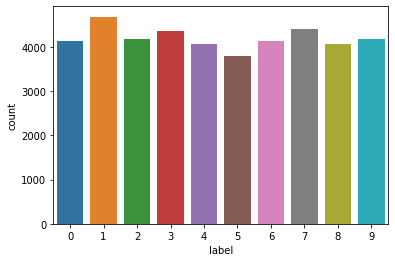

In [ ]:
train = pd.read_csv("train.csv.zip")
test = pd.read_csv("test.csv.zip")

Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1) 

del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

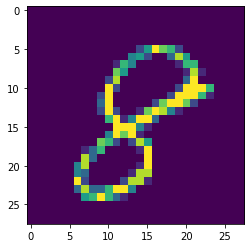

In [ ]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)

random_seed = 2

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
g = plt.imshow(X_train[0][:,:,0])


In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 5
batch_size = 86

In [ ]:
try1 = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2)

Epoch 1/5
440/440 - 7s - loss: 0.2330 - accuracy: 0.9237 - val_loss: 0.0584 - val_accuracy: 0.9814
Epoch 2/5
440/440 - 7s - loss: 0.0762 - accuracy: 0.9774 - val_loss: 0.0448 - val_accuracy: 0.9869
Epoch 3/5
440/440 - 7s - loss: 0.0526 - accuracy: 0.9842 - val_loss: 0.0366 - val_accuracy: 0.9900
Epoch 4/5
440/440 - 6s - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.0322 - val_accuracy: 0.9912
Epoch 5/5
440/440 - 6s - loss: 0.0400 - accuracy: 0.9889 - val_loss: 0.0405 - val_accuracy: 0.9888


##Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
439/439 - 15s - loss: 0.1221 - accuracy: 0.9637 - val_loss: 0.0315 - val_accuracy: 0.9919
Epoch 2/5
439/439 - 16s - loss: 0.0834 - accuracy: 0.9752 - val_loss: 0.0284 - val_accuracy: 0.9919
Epoch 3/5
439/439 - 15s - loss: 0.0683 - accuracy: 0.9800 - val_loss: 0.0341 - val_accuracy: 0.9917
Epoch 4/5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 - 15s - loss: 0.0667 - accuracy: 0.9800 - val_loss: 0.0338 - val_accuracy: 0.9907
Epoch 5/5
439/439 - 15s - loss: 0.0494 - accuracy: 0.9856 - val_loss: 0.0396 - val_accuracy: 0.9917


##Results & Submission

In [ ]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("digitrecogniser2.csv",index=False)

scored 0.99071 on kaggle